# Forecast Number of Visitors to a Restaurant
***

### Description:
Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business.

One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

Dataset Source: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data
***


### Time Series forecasting Introduction
Time series is a series of data points measured at consistent time intervals such as yearly, daily, monthly, hourly and so on. It is time-dependent & the progress of time is an important aspect of the data set. One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for Auto Regressive Integrated Moving Average. ARIMA is a model that can be fitted to time series data to predict future points in the series.

We can split the Arima term into three terms, AR, I, MA:

**AR(p) stands for the autoregressive model, the p parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead.**

An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.
***

**I(d) is the differencing part, the d parameter tells how many differencing orders are going to be used to make the series stationary.**

_First Order Differencing_

Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

_Second order differencing_

Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

***


**MA(q) stands for moving average model, the q is the number of lagged forecast error terms in the prediction equation.** 

SARIMA is seasonal ARIMA and it is used with time series with seasonality.

# Importing Standard imports and load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders (Grid Search)

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'                                          # Since Dataset has a timeseries frequency of Daily 

# Exploratory Data Analysis

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [3]:
#Check for any NaN
df.isnull().sum() 

weekday          0
holiday          0
holiday_name     0
rest1           39
rest2           39
rest3           39
rest4           39
total           39
dtype: int64

In [4]:
#Save df with dropped NaN to df1
df1 = df.dropna() 

In [5]:
#Check again for NaN
df1.isnull().sum()

weekday         0
holiday         0
holiday_name    0
rest1           0
rest2           0
rest3           0
rest4           0
total           0
dtype: int64

### Plot showing 'total' over time, including lines where Dates have holidays

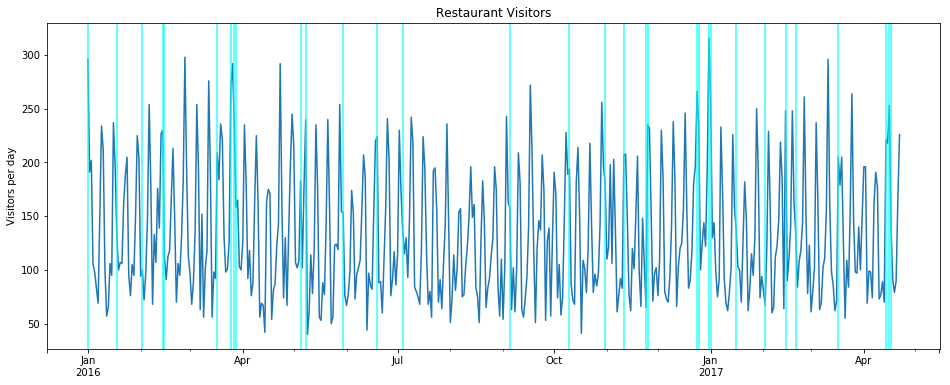

In [6]:
title = 'Restaurant Visitors'
ylabel= 'Visitors per day'
xlabel = '' # Empty xlabel

ax = df1['total'].plot(figsize=(16,6), title=title)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Rather than using a separate plot, use matplotlib to highlight holidays on the current plot
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='cyan', alpha = 0.8);  # add a semi-transparent cyan line

### ETS Decomposition plot to show Trend, Seasonal, and Residual

**Below is a function to plot out the individual plots from seasonal_decompose(). Do reuse it in the future**

In [7]:
def decomposition_plots(df):
    decomposition = seasonal_decompose(df)
    
    # Gathering trend, seasoanlity and noise of df
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

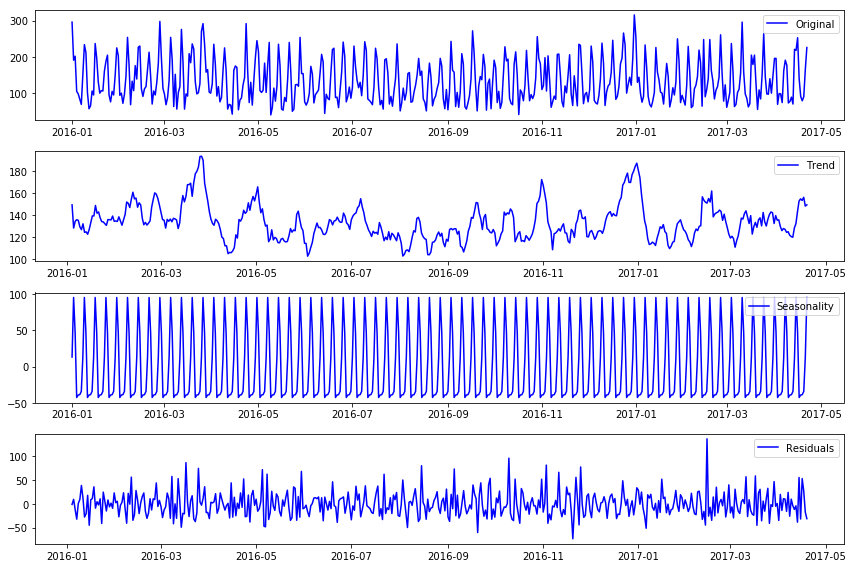

In [8]:
decomposition_plots(df1['total'])

The plot shows both trend & seasonality of the data but visual assumptions are not reliable

A confirmation is required using a Statistical test, Dickey-Fuller Hypothesis testing.

__Null Hypothesis:__ The series is not stationary.

__Alternate Hypothesis:__ The series is stationary.

**Below is a function created using adfuller to test for stationarity. Do reuse for future**

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders (Grid search)

For SARIMA Orders we set seasonal=True and pass in an m value

$m$ represents the number of data points (rows) in each seasonal cycle. **Eg: 7 days in a week, 12 months in a year**

In [11]:
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Thu, 07 Jan 2021   AIC                           4845.442
Time:                                   13:39:45   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5662      4.363      4.714      0.000      12.015      29.118
ar.L1          0.1897      0.045      4.221      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.3967     86.679     16.468      0.000    1257.510    1597.283
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

_The recommended order provides an **ARIMA Order of (1, 0, 0)** and a **seasonal order of (2, 0, 0, 7)**_

_Now to train & test the SARIMA model, followed by evaluation_

### Split the data into train and test

In [12]:
len(df1)

478

There are 478 days or approxmiately 68 weeks. A test size of 6 weeks will be used

In [13]:
# Set 6 weeks or 42 days for test set
train = df1.iloc[:-42]
test = df1.iloc[-42:]

### Fit a SARIMA (1, 0, 0)(2, 0, 0, 7) Model

In [14]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Thu, 07 Jan 2021   AIC                           4457.403
Time:                                   13:39:45   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Perform forecasting and stores in <tt>predictions</tt>

In [15]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

### Plot predictions against known values (Test set)

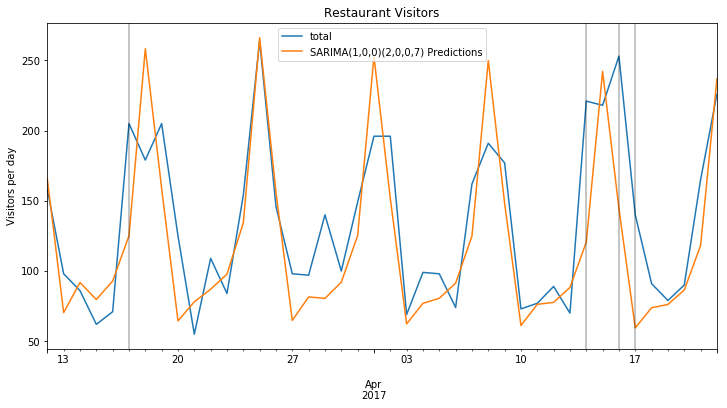

In [16]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Model Evaluation

In [17]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647958
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315497


***
There is an external factor "holidays" in the dataset. There is a possibility it can influence the forecasting.

### Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX)
SARIMAX considers external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

**NOTE:** eXogenous variable must be future dates that are certain. Example: Holidays, business quarterly earnings, yearly finance statements
***

### Now add in exogenous variable, 
using the same recommended **ARIMA Order of (1, 0, 0)** and a **seasonal order of (2, 0, 0, 7)**

In [18]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Thu, 07 Jan 2021   AIC                           4326.963
Time:                                   13:39:46   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8887      4.241     15.774      0.000      58.577      75.200
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3953     73.301     15.244      0.000     973.727    1261.063
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Perform forecasting and stores in <tt>predictions</tt>

In [19]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

### Plot predictions against known values (Test set)

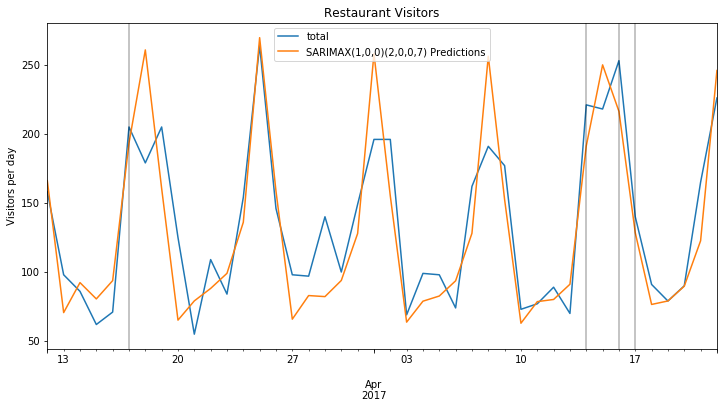

In [20]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### SARIMAX Model Evaluation 

In [21]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647958
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315497

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 950.6692299
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 30.83292445



_Adding in an exogenous variable, 'Holidays' did improve on the model accuracy._

***

### Retrain the model on the full data, and forecast the future 
using the same recommended **ARIMA Order of (1, 0, 0)** and a **seasonal order of (2, 0, 0, 7)**

The model will then be used to forecast 39 days into the future, and use the additional holiday data from the original dataframe, df

In [22]:
df.isnull().sum()

weekday          0
holiday          0
holiday_name     0
rest1           39
rest2           39
rest3           39
rest4           39
total           39
dtype: int64

There are 39 rows of NULL values to be filled in with the forecast values, with consideration of exogenous variable, 'holiday'

In [23]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

### Plot the forecast alongside historical values

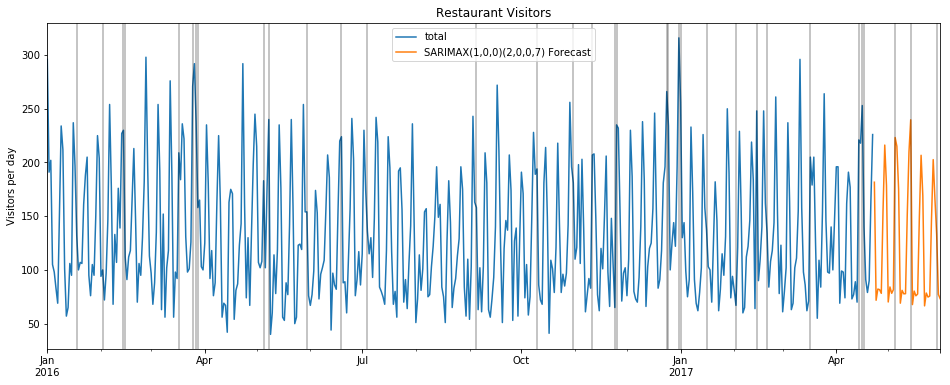

In [24]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);